<a href="https://colab.research.google.com/github/yyeseull/Codestates_AI13/blob/main/AI_13_%EC%84%9C%EC%98%88%EC%8A%AC_section2_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 신용카드 승인 예측

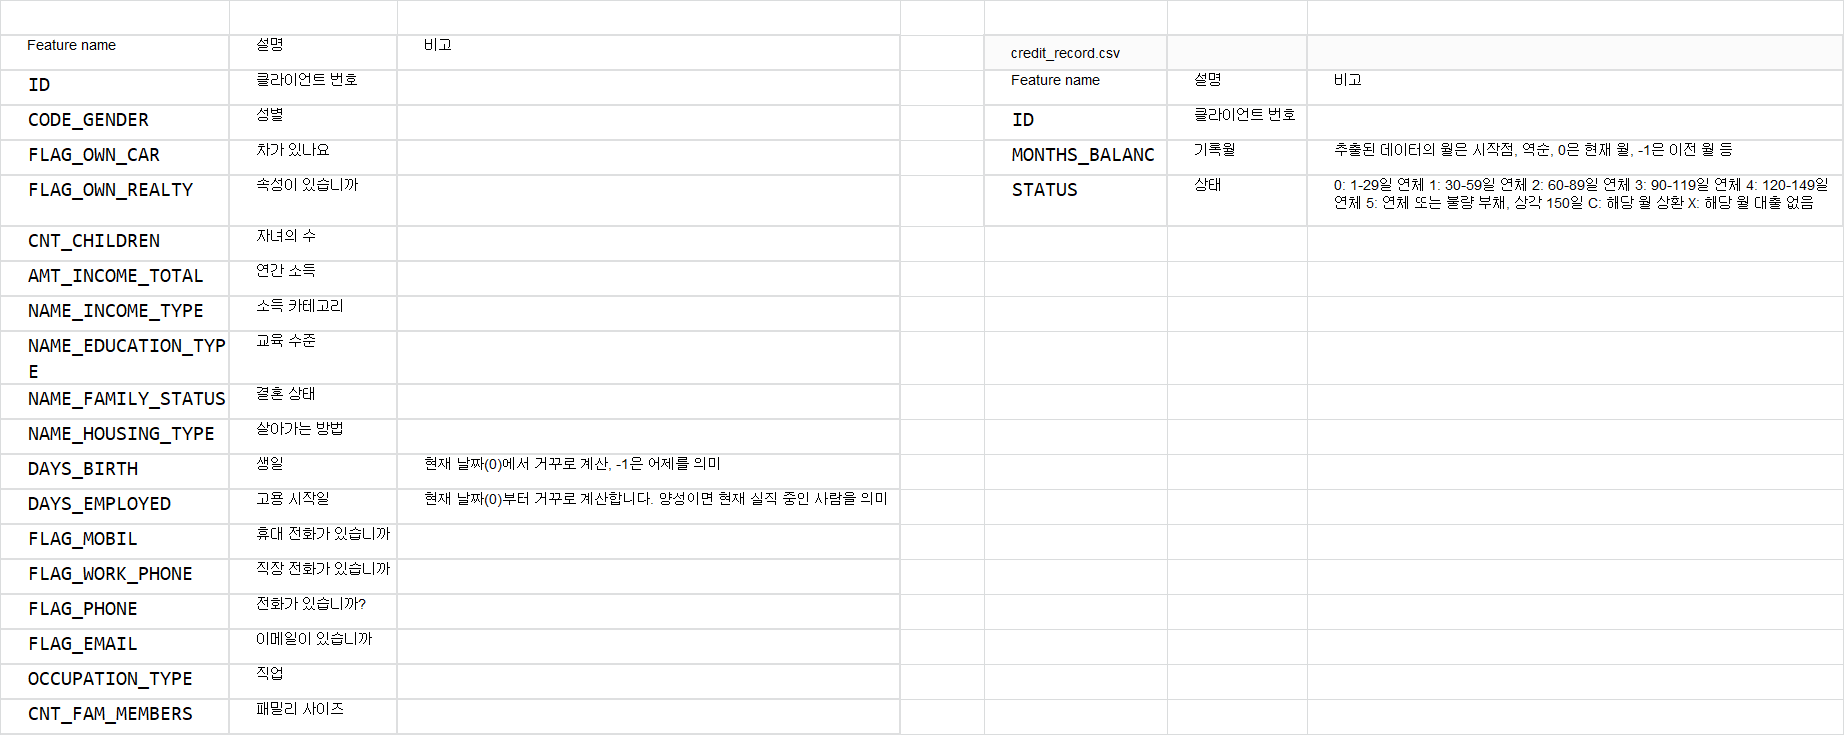

In [1]:
!pip install category_encoders
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install pdpbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from category_encoders import OrdinalEncoder, TargetEncoder, OneHotEncoder
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score, roc_curve, confusion_matrix, recall_score,precision_score
import warnings
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
from scipy.stats import randint, uniform
import shap

In [5]:
from google.colab import drive
drive.mount('/content/drive')

credit_record=pd.read_csv('/content/drive/MyDrive/archive/credit_record.csv') 
application_record=pd.read_csv('/content/drive/MyDrive/archive/application_record.csv') 


application_record

Mounted at /content/drive


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0


In [6]:
credit_record.head()


,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [7]:
# application_record.T.duplicated() #중복확인


In [8]:
# credit_record.T.duplicated()

# EDA

In [9]:
#결측치확인
application_record.isna().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
dtype: int64

In [10]:
credit_record.isna().sum()

ID                0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

In [11]:
application_record.nunique()

ID                     438510
CODE_GENDER                 2
FLAG_OWN_CAR                2
FLAG_OWN_REALTY             2
CNT_CHILDREN               12
AMT_INCOME_TOTAL          866
NAME_INCOME_TYPE            5
NAME_EDUCATION_TYPE         5
NAME_FAMILY_STATUS          5
NAME_HOUSING_TYPE           6
DAYS_BIRTH              16379
DAYS_EMPLOYED            9406
FLAG_MOBIL                  1
FLAG_WORK_PHONE             2
FLAG_PHONE                  2
FLAG_EMAIL                  2
OCCUPATION_TYPE            18
CNT_FAM_MEMBERS            13
dtype: int64

In [12]:
credit_record.nunique()

ID                45985
MONTHS_BALANCE       61
STATUS                8
dtype: int64

In [13]:
application_record.info

<bound method DataFrame.info of              ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0       5008804           M            Y               Y             0   
1       5008805           M            Y               Y             0   
2       5008806           M            Y               Y             0   
3       5008808           F            N               Y             0   
4       5008809           F            N               Y             0   
...         ...         ...          ...             ...           ...   
438552  6840104           M            N               Y             0   
438553  6840222           F            N               N             0   
438554  6841878           F            N               N             0   
438555  6842765           F            N               Y             0   
438556  6842885           F            N               Y             0   

        AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  

In [14]:
credit_record.info

<bound method DataFrame.info of               ID  MONTHS_BALANCE STATUS
0        5001711               0      X
1        5001711              -1      0
2        5001711              -2      0
3        5001711              -3      0
4        5001712               0      C
...          ...             ...    ...
1048570  5150487             -25      C
1048571  5150487             -26      C
1048572  5150487             -27      C
1048573  5150487             -28      C
1048574  5150487             -29      C

[1048575 rows x 3 columns]>

In [15]:
application_record['CNT_FAM_MEMBERS'].value_counts()

2.0     233891
1.0      84492
3.0      77128
4.0      37356
5.0       5081
6.0        459
7.0        124
9.0          9
11.0         5
14.0         4
8.0          4
15.0         3
20.0         1
Name: CNT_FAM_MEMBERS, dtype: int64

In [16]:
application_record.query("CNT_CHILDREN ==2 & CNT_FAM_MEMBERS == 1").head() # 자녀2명인데 가족수가 1인 경우가 있는걸 봐서 가족 인원에 자녀는 포함이 되지 않은 것 같음! 

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
434494,5023641,M,Y,N,2,225000.0,Working,Secondary / secondary special,Married,House / apartment,-14776,-2212,1,0,0,0,Drivers,1.0
434543,5045457,M,Y,N,2,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-14452,-4249,1,0,0,0,Drivers,1.0
434960,5224385,F,N,N,2,135000.0,Working,Secondary / secondary special,Separated,House / apartment,-13104,-125,1,0,0,0,Laborers,1.0
435100,5307087,M,Y,Y,2,540000.0,Working,Secondary / secondary special,Married,House / apartment,-13718,-2490,1,0,1,0,Managers,1.0
435108,5313528,M,Y,Y,2,247500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-12597,-410,1,0,0,0,Laborers,1.0


In [17]:
application_record.query("DAYS_EMPLOYED >=0 ") 

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
7,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0
8,5008813,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0
9,5008814,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0
76,5008884,F,N,Y,0,315000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-20186,365243,1,0,0,0,NaN,1.0
160,5008974,F,N,Y,0,112500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-22319,365243,1,0,0,0,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438549,6840098,F,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438550,6840100,F,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438551,6840102,F,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0


In [18]:
application_record['NAME_HOUSING_TYPE'].value_counts()

House / apartment      393831
With parents            19077
Municipal apartment     14214
Rented apartment         5974
Office apartment         3922
Co-op apartment          1539
Name: NAME_HOUSING_TYPE, dtype: int64

In [19]:
application_record['NAME_FAMILY_STATUS'].value_counts()	

Married                 299828
Single / not married     55271
Civil marriage           36532
Separated                27251
Widow                    19675
Name: NAME_FAMILY_STATUS, dtype: int64

In [20]:
def eda_process(df):
  
  #생일을 나이로 변경! 
  df['DAYS_BIRTH'] = np.abs(df['DAYS_BIRTH']/365).round()
  #고용일 실직 = 0 , 나머지는 년으로 변경!
  df['DAYS_EMPLOYED'] = np.where(df["DAYS_EMPLOYED"] >=0,0,df["DAYS_EMPLOYED"])
  df['DAYS_EMPLOYED'] =np.abs(df['DAYS_EMPLOYED']/365).round()
  #replace column names 
  new_col_name = { 'DAYS_EMPLOYED' : 'YEARS_EMPLOYED',
                   'DAYS_BIRTH' : 'AGE'}
  df.rename(columns = new_col_name,inplace=True)
  #거주형태
  df['NAME_HOUSING_TYPE'] = np.where(df['NAME_HOUSING_TYPE'] =='With parents ','With parents ','apartment')
  #가족수 자녀까지 포함.
  df['CNT_FAM_MEMBERS'] = df['CNT_CHILDREN'] + df['CNT_FAM_MEMBERS']

  dropped_cols = ['CNT_CHILDREN']
  df.drop(dropped_cols,axis=1,inplace=True)
  #가족상태
  family_status = {'Single / not married':'Single',
                     'Separated':'Single',
                     'Widow':'Single',
                     'Civil marriage':'Married',
                    'Married':'Married'}
  df['NAME_FAMILY_STATUS'] = df['NAME_FAMILY_STATUS'].map(family_status)


  return df


application = eda_process(application_record)

application.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,AGE,YEARS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,427500.0,Working,Higher education,Married,apartment,33.0,12.0,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,427500.0,Working,Higher education,Married,apartment,33.0,12.0,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,112500.0,Working,Secondary / secondary special,Married,apartment,59.0,3.0,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,270000.0,Commercial associate,Secondary / secondary special,Single,apartment,52.0,8.0,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,270000.0,Commercial associate,Secondary / secondary special,Single,apartment,52.0,8.0,1,0,1,1,Sales staff,1.0


# **타겟**

*   신용카드 승인 거부 : 1
*   신용카드 승인 : 0

In [21]:
credit_record['MONTHS'] = credit_record['MONTHS_BALANCE']*-1
credit_record=credit_record.sort_values(['ID','MONTHS'], ascending=True)
credit_record.head()

,ID,MONTHS_BALANCE,STATUS,MONTHS
0,5001711,0,X,0
1,5001711,-1,0,1
2,5001711,-2,0,2
3,5001711,-3,0,3
4,5001712,0,C,0


In [22]:
credit_record['MONTHS'].value_counts() 

1     34436
2     34209
0     33856
3     33854
4     33365
      ...  
56     2109
57     1649
58     1255
59      820
60      415
Name: MONTHS, Length: 61, dtype: int64

In [23]:
credit_record['STATUS'].value_counts() 

C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: STATUS, dtype: int64

In [24]:
credit_record['STATUS'].replace({'C': 0, 'X' : 0}, inplace=True)
credit_record['STATUS'] =credit_record['STATUS'].astype('int')
credit_record['STATUS'] = credit_record['STATUS'].apply(lambda x:1 if x >= 1 else 0)
credit_record

,ID,MONTHS_BALANCE,STATUS,MONTHS
0,5001711,0,0,0
1,5001711,-1,0,1
2,5001711,-2,0,2
3,5001711,-3,0,3
4,5001712,0,0,0
...,...,...,...,...
1048570,5150487,-25,0,25
1048571,5150487,-26,0,26
1048572,5150487,-27,0,27
1048573,5150487,-28,0,28


In [25]:
credit_record['STATUS'].value_counts() 

0    1034381
1      14194
Name: STATUS, dtype: int64

In [26]:
credit1=pd.DataFrame(credit_record.groupby('ID').sum()['STATUS'])

credit1

,STATUS
ID,
5001711,0
5001712,0
5001713,0
5001714,0
5001715,0
...,...
5150482,0
5150483,0
5150484,0


In [27]:
credit2=pd.DataFrame(credit_record.groupby('ID').max()['MONTHS'])
credit2

,MONTHS
ID,
5001711,3
5001712,18
5001713,21
5001714,14
5001715,59
...,...
5150482,28
5150483,17
5150484,12


In [28]:
credit = pd.merge(credit1, credit2, on='ID')


credit

,STATUS,MONTHS
ID,,
5001711,0,3
5001712,0,18
5001713,0,21
5001714,0,14
5001715,0,59
...,...,...
5150482,0,28
5150483,0,17
5150484,0,12


In [29]:
credit['mean'] =credit['STATUS' ]/ credit['MONTHS' ]
credit

,STATUS,MONTHS,mean
ID,,,
5001711,0,3,0.0
5001712,0,18,0.0
5001713,0,21,0.0
5001714,0,14,0.0
5001715,0,59,0.0
...,...,...,...
5150482,0,28,0.0
5150483,0,17,0.0
5150484,0,12,0.0


In [30]:
credit['mean'].value_counts() 

0.000000    40266
0.166667      117
0.090909      110
0.142857      108
0.111111      105
            ...  
0.421053        1
0.196078        1
0.413043        1
0.882353        1
0.218182        1
Name: mean, Length: 402, dtype: int64

In [31]:
credit['APPROVAL'] = credit['mean'].apply(lambda x:0 if x <= 0.65 else 1)
credit.reset_index()

,ID,STATUS,MONTHS,mean,APPROVAL
0,5001711,0,3,0.0,0
1,5001712,0,18,0.0,0
2,5001713,0,21,0.0,0
3,5001714,0,14,0.0,0
4,5001715,0,59,0.0,0
...,...,...,...,...,...
45980,5150482,0,28,0.0,0
45981,5150483,0,17,0.0,0
45982,5150484,0,12,0.0,0
45983,5150485,0,1,0.0,0


In [32]:
credit['APPROVAL'].value_counts() 

0    45514
1      471
Name: APPROVAL, dtype: int64

In [33]:
credit=credit.drop(['STATUS',	'MONTHS',	'mean'], axis=1).reset_index()
credit

,ID,APPROVAL
0,5001711,0
1,5001712,0
2,5001713,0
3,5001714,0
4,5001715,0
...,...,...
45980,5150482,0
45981,5150483,0
45982,5150484,0
45983,5150485,0


0    0.989758
1    0.010242
Name: APPROVAL, dtype: float64


([<matplotlib.patches.Wedge at 0x7ff6b5cda310>,
 [Text(-1.099430578713352, 0.03538930050204621, ''),
  Text(1.0994305796452413, -0.035389271551263084, '')],
 [Text(-0.5996894065709192, 0.01930325481929793, '98.98'),
  Text(0.5996894070792224, -0.019303239027961678, '1.02')])

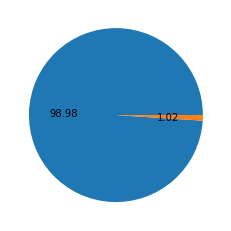

In [34]:
print(credit['APPROVAL'].value_counts(normalize=True,sort=False))
plt.pie(credit['APPROVAL'].value_counts(normalize = True), autopct='%.2f') #데이터 불균형


# **wrangling**

In [35]:
df = pd.merge(credit,application, on='ID',how = 'inner')
df

,ID,APPROVAL,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,AGE,YEARS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,0,M,Y,Y,427500.0,Working,Higher education,Married,apartment,33.0,12.0,1,1,0,0,NaN,2.0
1,5008805,0,M,Y,Y,427500.0,Working,Higher education,Married,apartment,33.0,12.0,1,1,0,0,NaN,2.0
2,5008806,0,M,Y,Y,112500.0,Working,Secondary / secondary special,Married,apartment,59.0,3.0,1,0,0,0,Security staff,2.0
3,5008808,0,F,N,Y,270000.0,Commercial associate,Secondary / secondary special,Single,apartment,52.0,8.0,1,0,1,1,Sales staff,1.0
4,5008809,0,F,N,Y,270000.0,Commercial associate,Secondary / secondary special,Single,apartment,52.0,8.0,1,0,1,1,Sales staff,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5150482,0,F,Y,Y,157500.0,Working,Secondary / secondary special,Married,apartment,30.0,5.0,1,0,0,0,Core staff,4.0
36453,5150483,0,F,Y,Y,157500.0,Working,Secondary / secondary special,Married,apartment,30.0,5.0,1,0,0,0,Core staff,4.0
36454,5150484,0,F,Y,Y,157500.0,Working,Secondary / secondary special,Married,apartment,30.0,5.0,1,0,0,0,Core staff,4.0
36455,5150485,0,F,Y,Y,157500.0,Working,Secondary / secondary special,Married,apartment,30.0,5.0,1,0,0,0,Core staff,4.0


In [36]:
df.describe()

,ID,APPROVAL,AMT_INCOME_TOTAL,AGE,YEARS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
count,3.645700e+04,36457.000000,3.645700e+04,36457.000000,36457.00000,36457.0,36457.000000,36457.000000,36457.000000,36457.000000
mean,5.078227e+06,0.011191,1.866857e+05,43.777382,6.03810,1.0,0.225526,0.294813,0.089722,2.628768
std,4.187524e+04,0.105197,1.017892e+05,11.519211,6.48948,0.0,0.417934,0.455965,0.285787,1.608041
min,5.008804e+06,0.000000,2.700000e+04,21.000000,0.00000,1.0,0.000000,0.000000,0.000000,1.000000
25%,5.042028e+06,0.000000,1.215000e+05,34.000000,1.00000,1.0,0.000000,0.000000,0.000000,2.000000
50%,5.074614e+06,0.000000,1.575000e+05,43.000000,4.00000,1.0,0.000000,0.000000,0.000000,2.000000
75%,5.115396e+06,0.000000,2.250000e+05,53.000000,9.00000,1.0,0.000000,1.000000,0.000000,4.000000
max,5.150487e+06,1.000000,1.575000e+06,69.000000,43.00000,1.0,1.000000,1.000000,1.000000,39.000000


In [37]:
df.isna().sum()

ID                         0
APPROVAL                   0
CODE_GENDER                0
FLAG_OWN_CAR               0
FLAG_OWN_REALTY            0
AMT_INCOME_TOTAL           0
NAME_INCOME_TYPE           0
NAME_EDUCATION_TYPE        0
NAME_FAMILY_STATUS         0
NAME_HOUSING_TYPE          0
AGE                        0
YEARS_EMPLOYED             0
FLAG_MOBIL                 0
FLAG_WORK_PHONE            0
FLAG_PHONE                 0
FLAG_EMAIL                 0
OCCUPATION_TYPE        11323
CNT_FAM_MEMBERS            0
dtype: int64

In [38]:
# 결측치 실제 값 확인 -> NaN
df[df["OCCUPATION_TYPE"].isnull()].head(5)

,ID,APPROVAL,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,AGE,YEARS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,0,M,Y,Y,427500.0,Working,Higher education,Married,apartment,33.0,12.0,1,1,0,0,NaN,2.0
1,5008805,0,M,Y,Y,427500.0,Working,Higher education,Married,apartment,33.0,12.0,1,1,0,0,NaN,2.0
7,5008812,0,F,N,Y,283500.0,Pensioner,Higher education,Single,apartment,62.0,0.0,1,0,0,0,NaN,1.0
8,5008813,0,F,N,Y,283500.0,Pensioner,Higher education,Single,apartment,62.0,0.0,1,0,0,0,NaN,1.0
9,5008814,0,F,N,Y,283500.0,Pensioner,Higher education,Single,apartment,62.0,0.0,1,0,0,0,NaN,1.0


In [39]:
df["OCCUPATION_TYPE"].value_counts() 

Laborers                 6211
Core staff               3591
Sales staff              3485
Managers                 3012
Drivers                  2138
High skill tech staff    1383
Accountants              1241
Medicine staff           1207
Cooking staff             655
Security staff            592
Cleaning staff            551
Private service staff     344
Low-skill Laborers        175
Waiters/barmen staff      174
Secretaries               151
HR staff                   85
Realty agents              79
IT staff                   60
Name: OCCUPATION_TYPE, dtype: int64

In [40]:
df.dtypes

ID                       int64
APPROVAL                 int64
CODE_GENDER             object
FLAG_OWN_CAR            object
FLAG_OWN_REALTY         object
AMT_INCOME_TOTAL       float64
NAME_INCOME_TYPE        object
NAME_EDUCATION_TYPE     object
NAME_FAMILY_STATUS      object
NAME_HOUSING_TYPE       object
AGE                    float64
YEARS_EMPLOYED         float64
FLAG_MOBIL               int64
FLAG_WORK_PHONE          int64
FLAG_PHONE               int64
FLAG_EMAIL               int64
OCCUPATION_TYPE         object
CNT_FAM_MEMBERS        float64
dtype: object

# 이상치

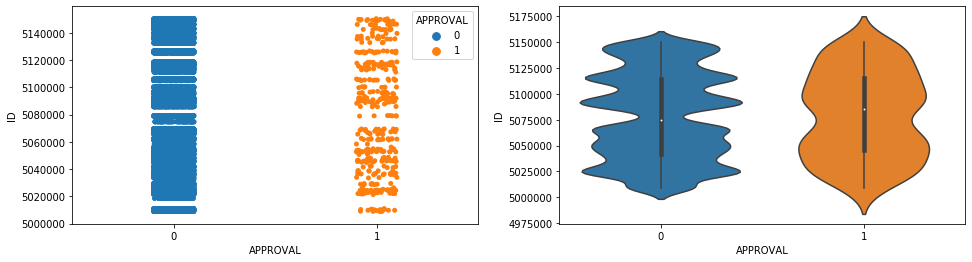

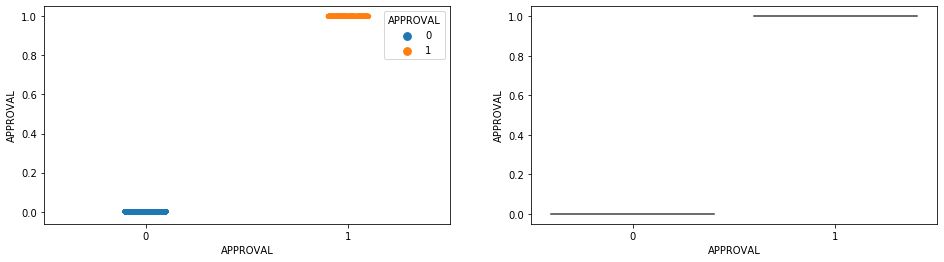

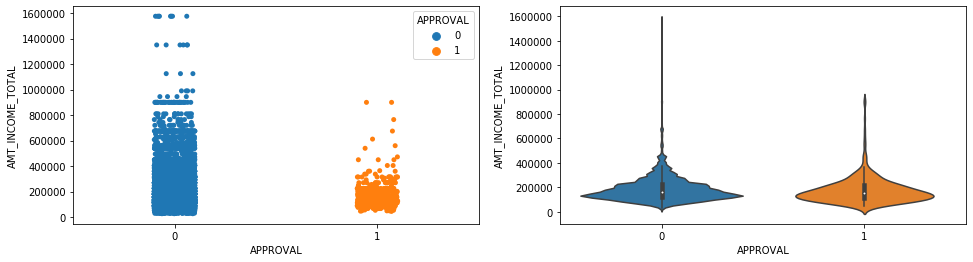

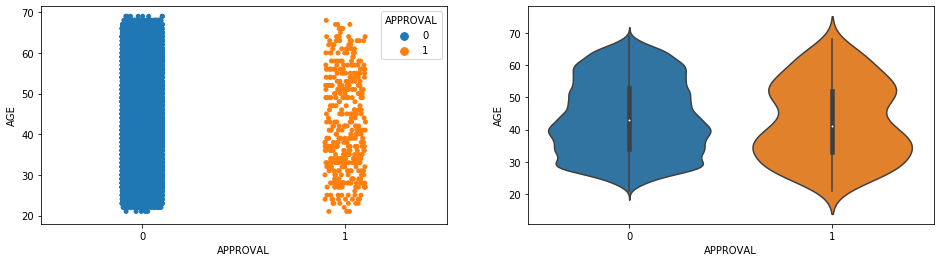

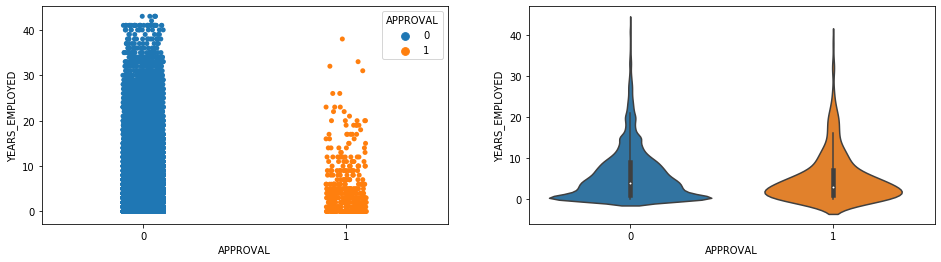

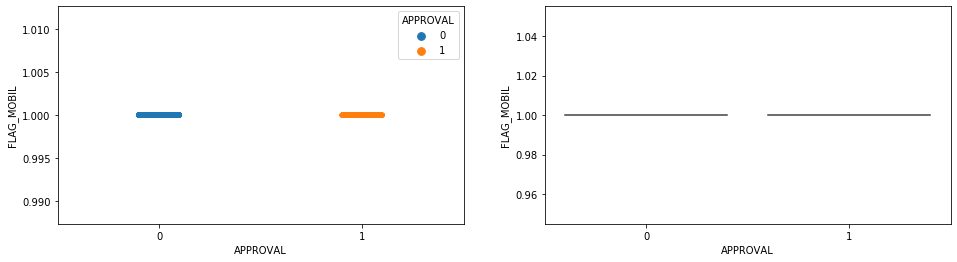

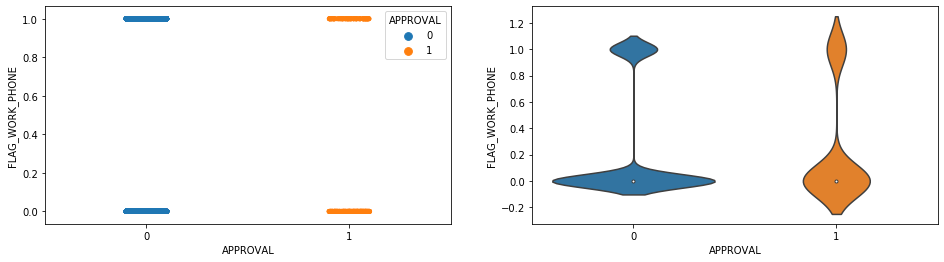

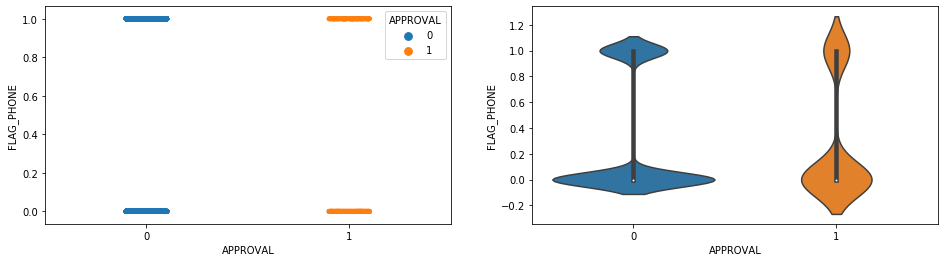

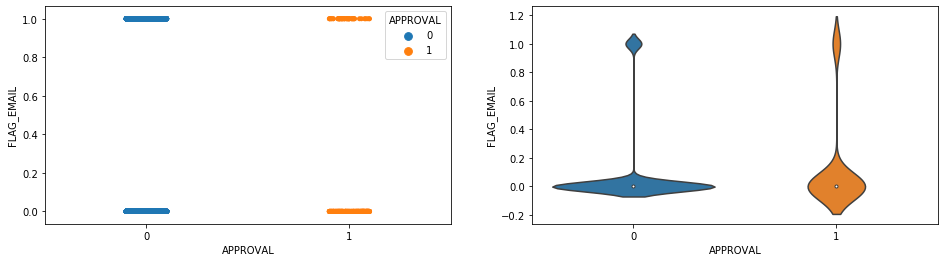

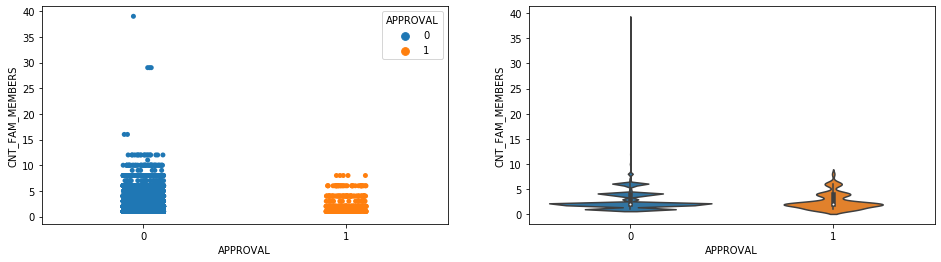

In [41]:
numerical_columns =df.select_dtypes(exclude=['object','int']).columns.tolist()

def show_dist_plot(df, columns):
    for column in columns:
        f, ax = plt.subplots(1,2,figsize=(16,4))
        sns.stripplot(x=df['APPROVAL'],y=df[column], ax=ax[0],hue=df['APPROVAL'])
        sns.violinplot(data=df, x='APPROVAL', y=column, ax=ax[1])
        
show_dist_plot(df, numerical_columns)

In [42]:
#이상치 제거! 싱글인데 가족 구성원 인원이 너무 많은 것으로 보아 지우기로 결정! 
df.query("CNT_FAM_MEMBERS >=20 ")



,ID,APPROVAL,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,AGE,YEARS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
14132,5061207,0,M,Y,Y,225000.0,Working,Secondary / secondary special,Single,apartment,49.0,5.0,1,0,0,0,Drivers,29.0
14133,5061210,0,M,Y,Y,225000.0,Working,Secondary / secondary special,Single,apartment,49.0,5.0,1,0,0,0,Drivers,29.0
14134,5061211,0,M,Y,Y,225000.0,Working,Secondary / secondary special,Single,apartment,49.0,5.0,1,0,0,0,Drivers,29.0
24753,5105054,0,F,N,Y,112500.0,Working,Secondary / secondary special,Single,apartment,30.0,5.0,1,1,1,0,Waiters/barmen staff,39.0


In [43]:
df=df.query("CNT_FAM_MEMBERS <=20 ")
df.query("CNT_FAM_MEMBERS >=20 ")



,ID,APPROVAL,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,AGE,YEARS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS


# **process**

In [44]:
target='APPROVAL'
train, test = train_test_split(df, test_size=0.2, random_state=42)

train, val = train_test_split(train, test_size = 0.20,
                              stratify = train[target], random_state = 42)

print(train.shape, val.shape, test.shape)


(23329, 18) (5833, 18) (7291, 18)


In [45]:
def delete_process(df):
      
    delete = ['FLAG_MOBIL','ID']
    df = df.drop(columns = delete)

    return df

train_processed = delete_process(train)
test_processed = delete_process(test)

In [46]:
max(train_processed['APPROVAL'].value_counts(normalize=True))

0.988769342877963

In [47]:
features = train_processed.columns.drop([target])
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]
X_train.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,AGE,YEARS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
12813,F,Y,Y,225000.0,Working,Higher education,Married,apartment,45.0,8.0,0,0,0,NaN,2.0
22921,M,Y,Y,297000.0,Working,Secondary / secondary special,Married,apartment,56.0,3.0,0,1,0,NaN,2.0
28039,M,Y,Y,126000.0,Working,Secondary / secondary special,Married,apartment,45.0,9.0,1,1,0,Drivers,6.0
33695,F,N,N,180000.0,Working,Secondary / secondary special,Married,apartment,50.0,12.0,1,1,0,Accountants,2.0
24259,M,Y,Y,157500.0,Working,Secondary / secondary special,Married,apartment,47.0,3.0,0,0,0,High skill tech staff,2.0


In [48]:
encoder = OneHotEncoder(use_cat_names=True)

X_train_encoder = encoder.fit_transform(X_train) 
X_val_encoder  = encoder.transform(X_val) 
X_test_encoder=  encoder.transform(X_test) 


#  **smote**

In [49]:

# logregression = LogisticRegression()
# logregression.fit(X_train_encoder, y_train)

# logregression.score(X_test_encoder, y_test)

# y_pred_logreg = logregression.predict(X_test_encoder)
# print(confusion_matrix(y_test, y_pred_logreg))

# print(classification_report(y_test, y_pred_logreg))

In [50]:
smote = SMOTE(random_state = 42)

X_train_smote, y_train_smote = smote.fit_resample(X_train_encoder, y_train)
# X_val_smote, y_val_smote = smote.fit_resample(X_val_encoder, y_val)

y_train_smote.value_counts()

0    23067
1    23067
Name: APPROVAL, dtype: int64

기준모델

In [51]:
max(y_train_smote.value_counts(normalize=True))

0.5

로즈스틱

In [52]:
logregression_smote = LogisticRegression()
logregression_smote.fit(X_train_smote, y_train_smote)

logregression_smote.score(X_test_encoder, y_test)

y_pred_logreg_smote = logregression_smote.predict(X_test_encoder)
print(confusion_matrix(y_test, y_pred_logreg_smote))

print(classification_report(y_test, y_pred_logreg_smote))

[[7211    0]
 [  80    0]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7211
           1       0.00      0.00      0.00        80

    accuracy                           0.99      7291
   macro avg       0.49      0.50      0.50      7291
weighted avg       0.98      0.99      0.98      7291



결정트리

In [53]:
pipe_smote_tree = make_pipeline(
    TargetEncoder(), 
		SimpleImputer(),
    DecisionTreeClassifier(random_state = 42, criterion = 'entropy', max_depth = 11)
)

pipe_smote_tree.fit(X_train_smote, y_train_smote)
print('훈련 정확도: ', pipe_smote_tree.score(X_train_smote, y_train_smote))
print('검증 정확도: ', pipe_smote_tree.score(X_val_encoder , y_val))

훈련 정확도:  0.9607664629123857
검증 정확도:  0.9694839705126007


In [54]:
y_pred_smote_tree = pipe_smote_tree.predict(X_test_encoder)
print(classification_report(y_test,y_pred_smote_tree))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      7211
           1       0.02      0.04      0.02        80

    accuracy                           0.97      7291
   macro avg       0.50      0.51      0.50      7291
weighted avg       0.98      0.97      0.97      7291



랜덤 포레스트

In [55]:
def fit_trees(X_train, y_train):
   
    pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_jobs = -1, oob_score=True,random_state=42))
    
    dist = {
    'simpleimputer__strategy': ['mean', 'median'],
     'randomforestclassifier__n_estimators': range(30,100),
     'randomforestclassifier__min_samples_leaf':range(1,30),
     'randomforestclassifier__min_samples_split':range(1,30),
     'randomforestclassifier__max_depth' : [5, 10 , 15, 20,30,40] 
     } 
    clf = RandomizedSearchCV(
    pipe, 
    param_distributions = dist,
    n_iter = 50 ,
    cv = 5,
    scoring = 'f1',
    verbose = 1,
    n_jobs = -1)
    clf.fit(X_train, y_train);
    

    return clf
clf_smote_forest = fit_trees(X_train_smote, y_train_smote)



Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [56]:
print("Best CV F1", clf_smote_forest.best_score_)
print("'최적 하이퍼파라미터", clf_smote_forest.best_params_)


Best CV F1 0.992971630916245
'최적 하이퍼파라미터 {'simpleimputer__strategy': 'median', 'randomforestclassifier__n_estimators': 92, 'randomforestclassifier__min_samples_split': 17, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__max_depth': 20}


In [57]:
# 가장 성능이 좋은 모델.
best_clf_smote_forest = clf_smote_forest.best_estimator_

In [58]:
print('훈련 정확도: ', best_clf_smote_forest.score(X_train_smote, y_train_smote))
print('검증 정확도: ', best_clf_smote_forest.score(X_val_encoder , y_val))

훈련 정확도:  0.9933454718862444
검증 정확도:  0.985599177095834


In [59]:
y_pred_smote_forest = best_clf_smote_forest.predict(X_test_encoder)
print(classification_report(y_test, y_pred_smote_forest))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7211
           1       0.06      0.03      0.04        80

    accuracy                           0.99      7291
   macro avg       0.53      0.51      0.51      7291
weighted avg       0.98      0.99      0.98      7291



XGBoost 모델

In [60]:


model = XGBClassifier(n_estimators=1000,
                      max_depth=7,
                      learning_rate=0.2,
                      n_jobs=-1)

model.fit(X_train_smote, y_train_smote)
XGBClassifier(learning_rate=0.2, max_depth=7, n_estimators=1000, n_jobs=-1)
y_pred_smote_XG = model.predict(X_test_encoder)


accuracy_score(y_test, y_pred_smote_XG)

0.9832670415580853

In [61]:
print(classification_report(y_test, y_pred_smote_XG))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7211
           1       0.06      0.04      0.05        80

    accuracy                           0.98      7291
   macro avg       0.53      0.52      0.52      7291
weighted avg       0.98      0.98      0.98      7291



# **가중치**

In [62]:


   
pipe =  pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(class_weight='balanced',n_jobs = -1, oob_score=True,random_state=42)) 

dist = {
    'simpleimputer__strategy': ['mean', 'median'],
     'randomforestclassifier__n_estimators': range(30,100),
     'randomforestclassifier__min_samples_leaf':range(1,30),
     'randomforestclassifier__min_samples_split':range(1,30),
     'randomforestclassifier__max_depth' : [5, 10 , 15, 20,30,40] 
     } 
clf_forest_class= RandomizedSearchCV(
    pipe, 
    param_distributions = dist,
    n_iter = 50 ,
    cv = 10,
    scoring = 'f1',
    verbose = 1,
    n_jobs = -1)
clf_forest_class.fit(X_train, y_train);
    


print("Best CV F1", clf_forest_class.best_score_)
print("'최적 하이퍼파라미터", clf_forest_class.best_params_)


Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best CV F1 0.07499940536292851
'최적 하이퍼파라미터 {'simpleimputer__strategy': 'median', 'randomforestclassifier__n_estimators': 48, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_depth': 40}


In [63]:
best_clf_forest_class = clf_forest_class.best_estimator_

In [64]:
print('훈련 정확도: ', best_clf_forest_class.score(X_train, y_train))
print('검증 정확도: ', best_clf_forest_class.score(X_val , y_val))

훈련 정확도:  0.9688370697415234
검증 정확도:  0.9609120521172638


In [65]:
y_pred_forest_class = best_clf_forest_class.predict(X_test)
print(classification_report(y_test, y_pred_forest_class))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      7211
           1       0.06      0.19      0.09        80

    accuracy                           0.96      7291
   macro avg       0.53      0.58      0.54      7291
weighted avg       0.98      0.96      0.97      7291



In [142]:
pipe1 = Pipeline([
    ('preprocessing', make_pipeline(TargetEncoder(), SimpleImputer())),
    ('xgb', XGBClassifier(random_state = 42
                  , n_jobs = -1
                 )) 
])


dists2 = {
    'xgb__n_estimators': randint(50, 500), 
    'xgb__max_depth': [5, 10, 15, 20, None]}
    # 'xgb__learning_rate': uniform(0, 1) }


clf_xgb_class = RandomizedSearchCV(
    pipe1,
    param_distributions = dists2,
    n_iter = 50,
    cv = 5, 
    scoring = 'f1',  # 오차 평가방법
    verbose = 1
    # n_jobs = -1, 
)

#randomized Search CV로 train data 학습 진행
clf_xgb_class.fit(X_train, y_train);
# Fitting 3 folds for each of 50 candidates, totalling 150 fits
# CPU times: user 10min 47s, sys: 8.48 s, total: 10min 56s
# Wall time: 3h 4min 8s

print('최적 하이퍼파라미터: ', clf_xgb_class.best_params_)
print('accuracy: ', clf_xgb_class.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
최적 하이퍼파라미터:  {'xgb__max_depth': 10, 'xgb__n_estimators': 168}
accuracy:  0.06314176245210727


In [144]:
y_pred_XG_class = clf_xgb_class.predict(X_test)


accuracy_score(y_test, y_pred_XG_class )

0.9875188588670964

# **평가지표**

In [145]:

def metrics(y_test,pred):
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    roc_score = roc_auc_score(y_test,pred,average='macro')
    print('정확도 : {0:.2f}, 정밀도 : {1:.2f}, 재현율 : {2:.2f}'.format(accuracy,precision,recall))
    print('f1-score : {0:.2f}, auc : {1:.2f}'.format(f1,roc_score,recall))


print('가중치 랜덤포레스트 : ',metrics(y_test,y_pred_forest_class))
print('가중치 XGBoost 모델  : ',metrics(y_test,y_pred_XG_class))
print('smote XGBoost 모델  :',metrics(y_test, y_pred_smote_XG)) 
print('smote 랜덤 포레스트 :' ,metrics(y_test,y_pred_smote_forest)) 
print('smote 결정트리 :',metrics(y_test,y_pred_smote_tree))   
print('smote 로지스틱 :' ,metrics(y_test, y_pred_logreg_smote))

정확도 : 0.96, 정밀도 : 0.06, 재현율 : 0.19
f1-score : 0.09, auc : 0.58
가중치 랜덤포레스트 :  None
정확도 : 0.99, 정밀도 : 0.08, 재현율 : 0.01
f1-score : 0.02, auc : 0.51
가중치 XGBoost 모델  :  None
정확도 : 0.98, 정밀도 : 0.06, 재현율 : 0.04
f1-score : 0.05, auc : 0.52
smote XGBoost 모델  : None
정확도 : 0.99, 정밀도 : 0.06, 재현율 : 0.03
f1-score : 0.04, auc : 0.51
smote 랜덤 포레스트 : None
정확도 : 0.97, 정밀도 : 0.02, 재현율 : 0.04
f1-score : 0.02, auc : 0.51
smote 결정트리 : None
정확도 : 0.99, 정밀도 : 0.00, 재현율 : 0.00
f1-score : 0.00, auc : 0.50
smote 로지스틱 : None


              precision    recall  f1-score   support

           0       0.99      0.97      0.98      7211
           1       0.06      0.19      0.09        80

    accuracy                           0.96      7291
   macro avg       0.53      0.58      0.54      7291
weighted avg       0.98      0.96      0.97      7291



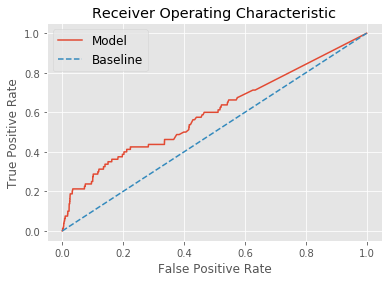

In [100]:

def predict(X, y, best_estimator):
  
    y_pred_proba = best_estimator.predict_proba(X)[:, 1]


    report = classification_report(y, y_pred_proba > 0.5)
    return y_pred_proba, report

def plot_roc(y, y_pred_proba):
    auc_score = roc_auc_score(y, y_pred_proba)
    fpr, tpr, _ = roc_curve(y, y_pred_proba)
    baseline_fpr, baseline_tpr, _ = roc_curve(y, [0] * len(y))

    plt.style.use("ggplot")
    plt.plot(fpr, tpr, label="Model")
    plt.plot(baseline_fpr, baseline_tpr, linestyle="--", label="Baseline")
    plt.xlabel("False Positive Rate", size=12)
    plt.ylabel("True Positive Rate", size=12)
    plt.title("Receiver Operating Characteristic")
    plt.legend(prop={"size": 12})
    plt.show()
    return auc_score


y_test_pred_proba, report = predict(X_test, y_test,clf_forest_class.best_estimator_)
print(report)
auc_score = plot_roc(y_test, y_test_pred_proba)


In [67]:
#특성중요도
def get_feature_importances(pipe, feature_names):
    feature_importances = np.zeros(len(feature_names))

    rf = clf_forest_class.best_estimator_.named_steps['randomforestclassifier']
    feature_importances = rf.feature_importances_


    return sorted(
        list(zip(feature_names, feature_importances)), key=lambda x: x[1], reverse=True
    )
feature_importances = get_feature_importances(
    clf_smote_forest.best_estimator_, list(X_train.columns)
)
for name, importance in feature_importances:
    print(f"{name}: {importance:.4f}")

AGE: 0.2067
AMT_INCOME_TOTAL: 0.1925
YEARS_EMPLOYED: 0.1403
OCCUPATION_TYPE: 0.1086
CNT_FAM_MEMBERS: 0.0650
NAME_EDUCATION_TYPE: 0.0497
NAME_INCOME_TYPE: 0.0443
FLAG_OWN_REALTY: 0.0348
FLAG_OWN_CAR: 0.0335
FLAG_PHONE: 0.0300
CODE_GENDER: 0.0296
FLAG_WORK_PHONE: 0.0283
NAME_FAMILY_STATUS: 0.0197
FLAG_EMAIL: 0.0170
NAME_HOUSING_TYPE: 0.0000


# **PDP,SHAP**

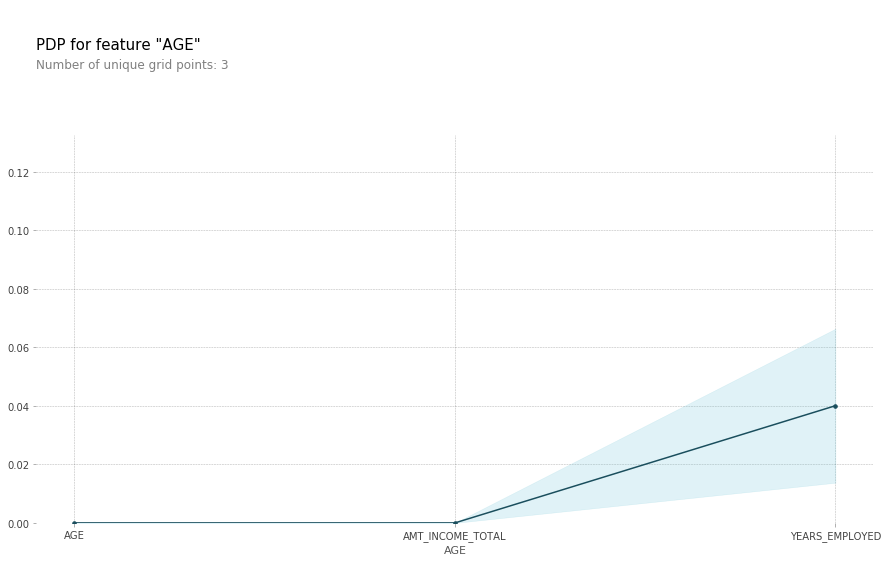

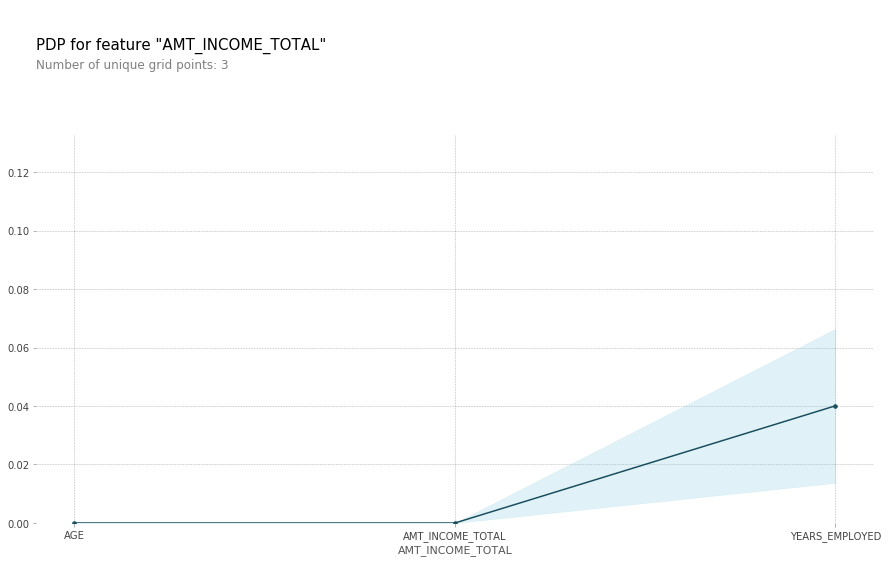

In [115]:
features1 = ['AGE', 'AMT_INCOME_TOTAL','YEARS_EMPLOYED']

for feature in features:
  isolated = pdp_isolate( model=clf_forest_class,
                          dataset=X_train, 
                          model_features=X_train.columns, 
                         feature=features1,
                         grid_type='percentile', 
                         num_grid_points=10)
  
  pdp_plot(isolated, feature_name=feature);

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff6adf3f810>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff6ae04cc90>})

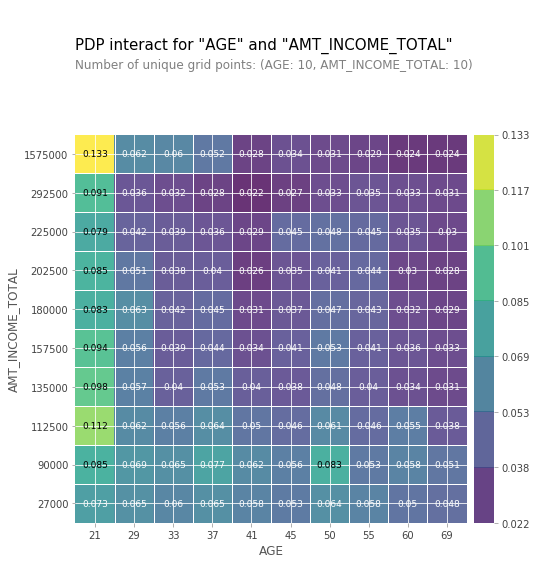

In [116]:
features = ['AGE', 'AMT_INCOME_TOTAL']

interaction = pdp_interact(model=clf_forest_class,
                           dataset=X_train,
                           model_features=X_train.columns,
                           features=features)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features)

In [112]:
explainer = shap.TreeExplainer(model)

row = X_test_encoder.iloc[[1]]
shap_values = explainer.shap_values(row)

shap.initjs();

shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)

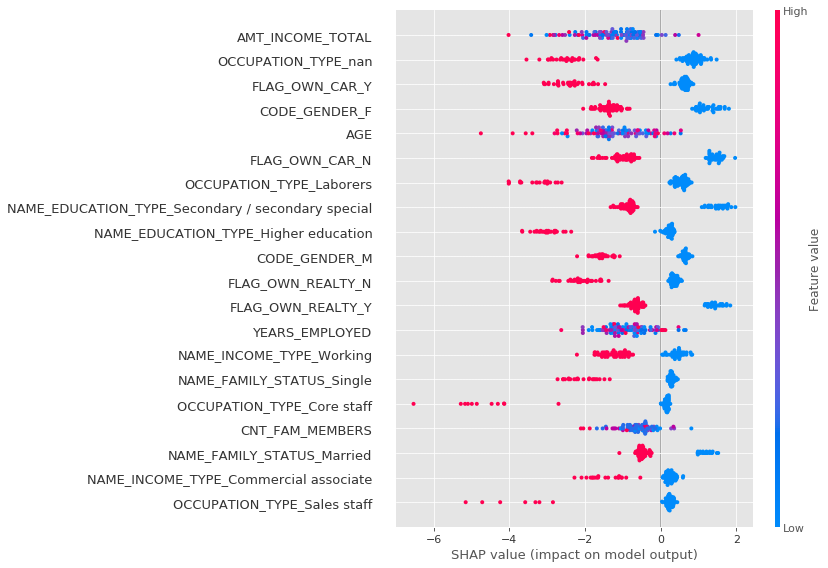

In [113]:
shap_values = explainer.shap_values(X_test_encoder.iloc[:100])
shap.summary_plot(shap_values, X_test_encoder.iloc[:100])